# Transfer Fee Prediction

The purpose of this application is to predict the transfer fee of a football player. This application is designed to be used on higher-profile transfers.

**Setup**

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pycountry
import pycountry_convert as pc
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

In [2]:
# Creating dataframe
df1 = pd.read_csv('datasets/transfer_data1.csv')
df2 = pd.read_csv('datasets/transfer_data2.csv')
df3 = pd.read_csv('datasets/transfer_data3.csv')

df = pd.concat([df1, df2, df3])

df.columns

Index(['name', 'position', 'country', 'season', 'market value', 'transfer fee',
       'left', 'joined', 'old club league', 'new club league',
       'old club league type', 'new club league type', 'age',
       'contract remaining'],
      dtype='object')

**Data Preprocessing**

The data has been scraped from Transfermarkt. It contains 250 of the most expensive transfers that took place each season from 2017 to 2022.

Converting Data Types

In [3]:
# Convert price in euros into integer
def to_int(p):
    p = p.replace('€', '')
    
    if 'm' in p:
        multiplier = 1000000
        val = p.replace('m', '')
    elif 'k' in p:
        multiplier = 1000
        val = p.replace('k', '')
    else:
        return None

    try:
        numeric_val = float(val)
        return int(numeric_val * multiplier)
    except ValueError:
        return None


# Convert date into number of days
def to_days(s):
    if not isinstance(s, str):
        return None
    
    time_components = list(map(int, re.findall(r'\d+', s)))
    
    if len(time_components) == 3:
        years, months, days = time_components
    elif len(time_components) == 2:
        years = 0
        months, days = time_components
    elif len(time_components) == 1:
        years = 0
        months = 0
        days = time_components[0]

    total_days = years*365 + months*30 + days

    return total_days


In [4]:
# Converting string types into integers/floats
df['market value'] = df['market value'].apply(to_int)
df['transfer fee'] = df['transfer fee'].apply(to_int)

df['age'] = df['age'].apply(to_days)
df['contract remaining'] = df['contract remaining'].apply(to_days)

Dropping Unnecessary Features

In [5]:
# Dropping missing values and unnecessary features
cols_drop = ['name', 'season', 'joined', 'old club league',
             'new club league', 'new club league type']
df.dropna(inplace=True)
df.drop(cols_drop, axis=1, inplace=True)

Reasons for dropping features:

name: unimportant for prediction

season: unimportant for prediction

joined: the purpose of the model is to predict a fee based on factors before a transfer takes place, prior to any knowledge of a player's final destination

old club league: 'league type' already encapsulates this informational value

new club league: same reason as 'joined'

new club league type: same reason as 'joined'

Binning Features

In [6]:
# Binning and Renaming Player Positions
df['position'].replace(['Left-Back', 'Right-Back',
                        'Left Midfield', 'Right Midfield',
                        'Centre-Back'], 
                        'Defender', inplace=True)

df['position'].replace(['Defensive Midfield','Central Midfield',
                        'Attacking Midfield'], 
                       'Midfielder', inplace=True)


df['position'].replace(['Left Winger', 'Right Winger',
                        'Second Striker', 'Centre-Forward'], 
                        'Attacker', inplace=True)

In [7]:
# Binning Countries into Continents

# Custom mapping dictionary for country to continent not in Pycountry
country_to_continent = {
    'England': 'Europe',
    'DR Congo': 'Africa',
    "Cote d'Ivoire": 'Africa',
    'Curacao': 'North America',
    'Scotland': 'Europe',
    'Bosnia-Herzegovina': 'Europe',
    'Kosovo': 'Europe',
    'Wales': 'Europe',
    'The Gambia': 'Africa',
    'Northern Ireland': 'Europe',
    'Korea, South': 'Asia',
    'Cape Verde': 'Africa'
}

def get_continent(country_name):
    if country_name in country_to_continent:
        return country_to_continent[country_name]
    else:
        country = pycountry.countries.search_fuzzy(country_name)[0]
        country_alpha2 = country.alpha_2
        country_alpha3 = country.alpha_3
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    
# Assuming your DataFrame is named 'df' and has a 'country' column
df['continent'] = df['country'].apply(get_continent)
df.drop(['country'], axis=1, inplace=True)

In [8]:
# Reording Columns such that the target is first
columns = df.columns.tolist()
columns.insert(0, columns.pop(columns.index('transfer fee')))

# Reorder the columns in the DataFrame
df = df[columns]

In [9]:
# Retaining high-profile transfers
df = df[df['market value'] >= 1000000]
df.head()

,transfer fee,position,market value,left,old club league type,age,contract remaining,continent
0,222000000.0,Attacker,100000000.0,FC Barcelona,First Tier,9304,1422.0,South America
1,140000000.0,Attacker,33000000.0,Borussia Dortmund,First Tier,7400,1400.0,Europe
2,135000000.0,Attacker,90000000.0,Liverpool FC,First Tier,9332,1632.0,South America
3,84700000.0,Attacker,50000000.0,Everton FC,First Tier,8817,715.0,Europe
4,84650000.0,Defender,30000000.0,Southampton FC,First Tier,9664,1639.0,Europe


In [10]:
df.columns

Index(['transfer fee', 'position', 'market value', 'left',
       'old club league type', 'age', 'contract remaining', 'continent'],
      dtype='object')

**Exploratory Data Analysis**

Encoding Ordinal Data

In [11]:
# Encoding Ordinal Data
le = LabelEncoder()
df['league tier'] = le.fit_transform(df['old club league type'])
df.drop('old club league type', axis=1, inplace=True)

Correlation Matrix Plot

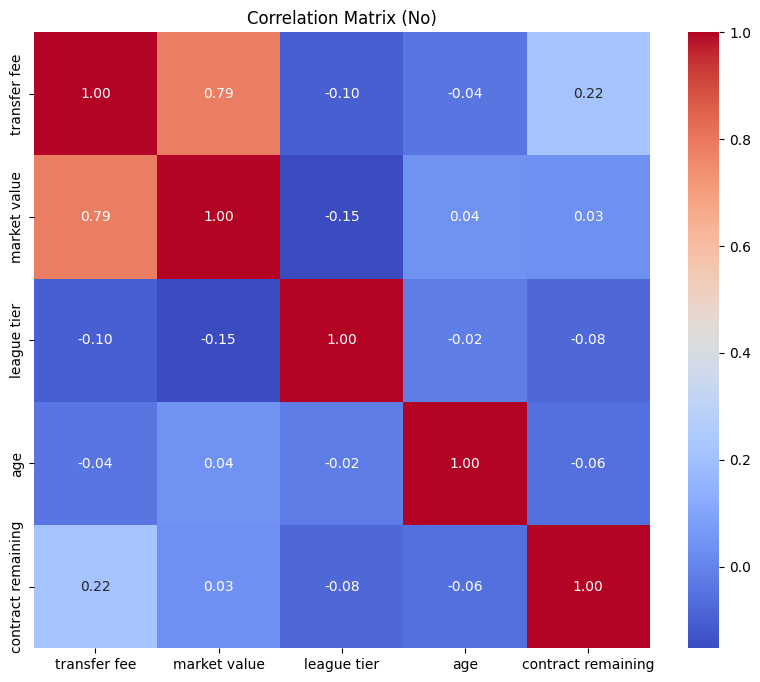

In [12]:
# Target and features that are not nominal
corr_df = df[['transfer fee', 'market value', 'league tier', 
             'age', 'contract remaining']]
correlation_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            cmap='coolwarm', square=True)

plt.title('Correlation Matrix (No)')
plt.show()

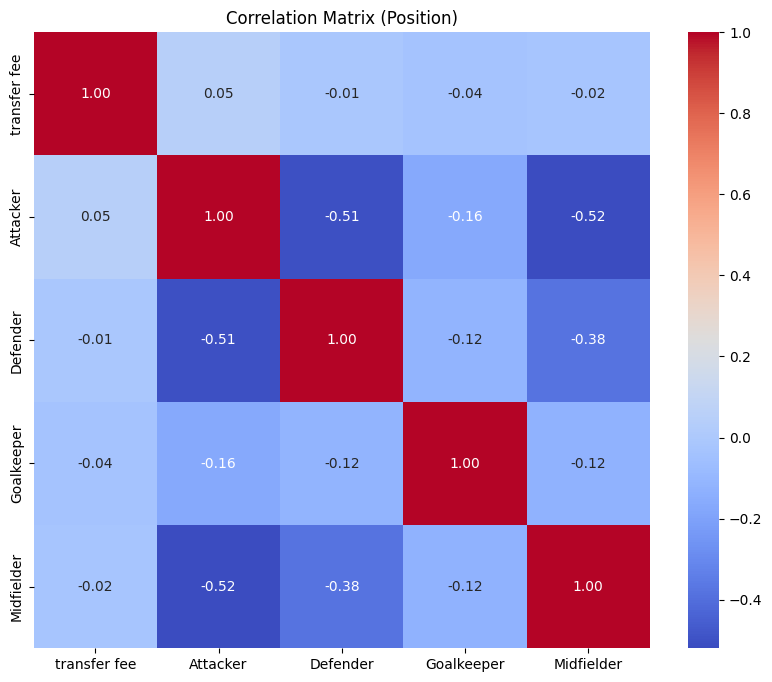

In [13]:
# Encode 'position' using one-hot encoding
encoded_df = pd.concat([df['transfer fee'], pd.get_dummies(df['position'])],
                       axis=1)

# Calculate correlation coefficients
correlation_matrix = encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            cmap='coolwarm', square=True)

plt.title('Correlation Matrix (Position)')
plt.show()

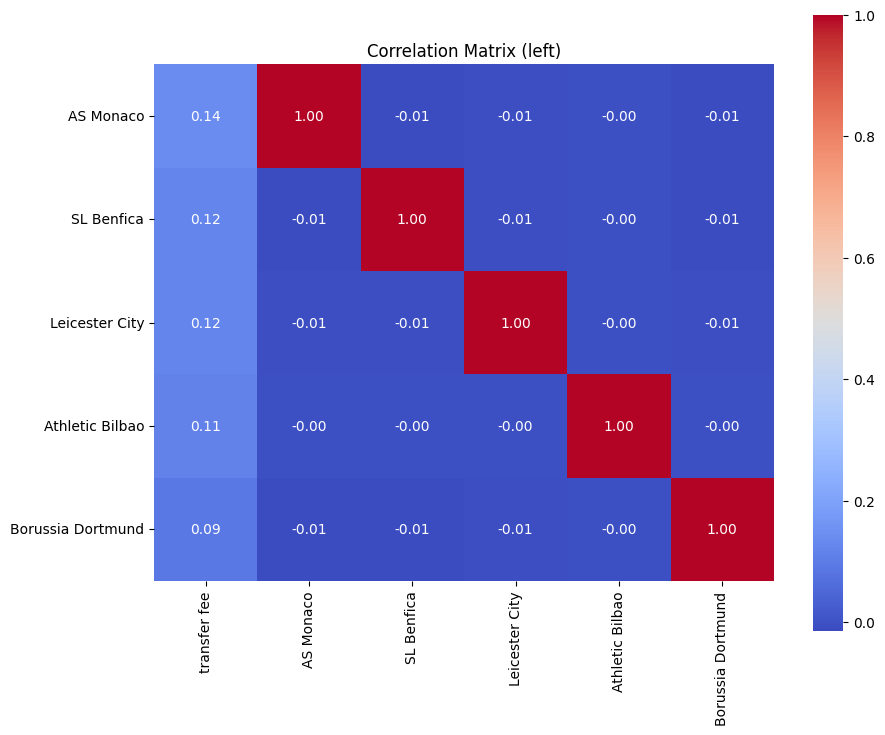

In [14]:
# Encode 'left' (club that player departed) using one-hot encoding
encoded_df = pd.concat([df['transfer fee'], pd.get_dummies(df['left'])],
                       axis=1)

# Calculate correlation coefficients
correlation_matrix = encoded_df.corr()

# Extract the correlation values between transfer fee and team names
correlation_with_transfer_fee = correlation_matrix['transfer fee']
correlation_with_transfer_fee = correlation_with_transfer_fee.drop('transfer fee')  # Remove self-correlation

# Sort correlation values in descending order and get the top 5 teams
top_teams = correlation_with_transfer_fee.abs().nlargest(5).index.tolist()

# Create a correlation matrix using the top 5 teams and transfer fee
subset_corr_matrix = correlation_matrix.loc[top_teams, ['transfer fee'] + top_teams]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr_matrix, annot=True, fmt='.2f',
            cmap='coolwarm', square=True)

plt.title('Correlation Matrix (left)')
plt.show()

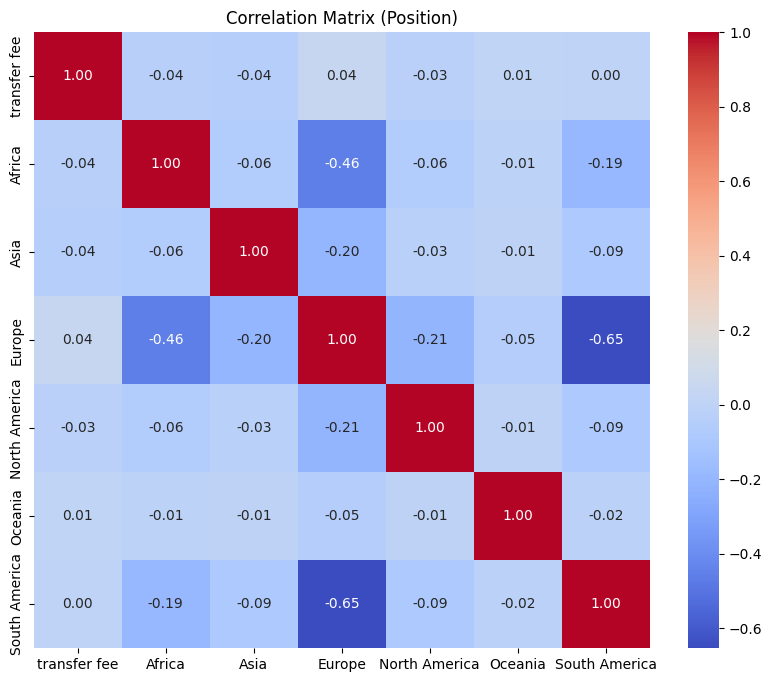

In [15]:
# Encode 'continent' using one-hot encoding
encoded_df = pd.concat([df['transfer fee'], pd.get_dummies(df['continent'])],
                       axis=1)

# Calculate correlation coefficients
correlation_matrix = encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            cmap='coolwarm', square=True)

plt.title('Correlation Matrix (Position)')
plt.show()

The correlation matrices above reveal that most of the nominal data show very little correlation with transfer fee. Features such as 'age' and the ordinal variable 'league tier' also show little correlation as well.

The reason behind this phenomenon is not unexpected, as most of these features are encapsulated by market value, determined by Transfermarkt. Transfermarkt, being a commonly used source for player valuations by clubs, comprehensively captures and reflects the various aspects that influence a player's value.

However, it is work looking into the 'left' feature as it may help improve our model's performance. Considering that the correlation coefficient values we see above are relatively low, we should only take into consideration values that are higher than 0.1.

Taking this into consideration, we should only focus on market value and contract remaining to predict transfer fee to maintain the model's robustness.

In [16]:
# Drop all other columns from the original DataFrame
df.drop(df.columns.difference(
    ['transfer fee', 'market value', 'contract remaining']), 
    axis=1, inplace=True)

In [17]:
df.head()

,transfer fee,market value,contract remaining
0,222000000.0,100000000.0,1422.0
1,140000000.0,33000000.0,1400.0
2,135000000.0,90000000.0,1632.0
3,84700000.0,50000000.0,715.0
4,84650000.0,30000000.0,1639.0


Scaling Data

In [18]:
# Standard Scaling
feature_scaler = StandardScaler()

features = ['market value','contract remaining']
df[features] = feature_scaler.fit_transform(df[features])

target_scaler = StandardScaler()
df['transfer fee'] = target_scaler.fit_transform(df[['transfer fee']])

Splitting Data into Training, Validation, and Testing Sets

In [19]:
# Features and Target
X = df[['market value', 'contract remaining']]
y = df['transfer fee']


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=0.2,
                                                    random_state=0, 
                                                    shuffle=True)
# Validation set split from Train set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=0, 
                                                  shuffle=True)

**ML Models**

Initial Model Evaluation

In [20]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regression', DecisionTreeRegressor()),
    ('Random Forest Regression', RandomForestRegressor()),
    ('SVR', SVR()),
    ('Gradient Boost', GradientBoostingRegressor()),
    ('XGBoost', XGBRegressor()),
    ('MLPRegressor', MLPRegressor(max_iter=2000))
]

In [21]:
for model_name, model in models:
    # Create a pipeline with the model
    pipeline = Pipeline(steps=[('model', model)])
    
    # Fit the model to the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Print the regression report
    print('=====================================================')
    print(model_name)
    print("Mean Absolute Error (MAE): {:.3f}".format(mae))
    print("Mean Squared Error (MSE): {:.3f}".format(mse))
    print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse))
    print("R-squared (R^2) score: {:.3f}".format(r2))
    print('=====================================================')

Linear Regression
Mean Absolute Error (MAE): 0.360
Mean Squared Error (MSE): 0.386
Root Mean Squared Error (RMSE): 0.622
R-squared (R^2) score: 0.636
Decision Tree Regression
Mean Absolute Error (MAE): 0.414
Mean Squared Error (MSE): 0.468
Root Mean Squared Error (RMSE): 0.684
R-squared (R^2) score: 0.559
Random Forest Regression
Mean Absolute Error (MAE): 0.358
Mean Squared Error (MSE): 0.362
Root Mean Squared Error (RMSE): 0.601
R-squared (R^2) score: 0.660
SVR
Mean Absolute Error (MAE): 0.332
Mean Squared Error (MSE): 0.398
Root Mean Squared Error (RMSE): 0.631
R-squared (R^2) score: 0.625
Gradient Boost
Mean Absolute Error (MAE): 0.332
Mean Squared Error (MSE): 0.338
Root Mean Squared Error (RMSE): 0.581
R-squared (R^2) score: 0.682
XGBoost
Mean Absolute Error (MAE): 0.381
Mean Squared Error (MSE): 0.416
Root Mean Squared Error (RMSE): 0.645
R-squared (R^2) score: 0.608
MLPRegressor
Mean Absolute Error (MAE): 0.339
Mean Squared Error (MSE): 0.355
Root Mean Squared Error (RMSE): 0.5

Upon the initial evaluation of the models, Decision Tree seems to be performing significantly worse than the other models so it is dropped. 

Hyperparameter Tuning with Grid Search on Validation Data Set

In [22]:
# Defining Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regression': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boost': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'MLPRegressor': MLPRegressor(max_iter=2000)
}

In [23]:
# Parameter grid for each model
param_grid = {
    'Linear Regression': {},
    'Random Forest Regression': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1, 2]
    },
    'SVR': {
        'C': [4, 5, 6, 7, 8], 
        'gamma': ['scale', 'auto']
        },
    'Gradient Boost': {
        'n_estimators': [25, 50, 75, 90], 
        'learning_rate': [0.05, 0.1, 0.15], 
        'max_depth': [1, 2, 3, 4], 
        'min_samples_split': [2, 5, 10, 15], 
        'min_samples_leaf': [3, 4, 5, 6]
        },
    'XGBoost': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [5, 10, 15],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(100,), (50,), (75,)], 
        'alpha': [0.0005, 0.001, 0.0012, 0.0013, 0.0015], 
        'activation': ['relu', 'tanh', 'logistic','identity']
        }
}

In [24]:
# Grid Search on each model
for model_name, model in models.items():
    print('=====================================================')
    print(f"Performing grid search for {model_name}")
    print('-----------------------------------------------------')
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid[model_name], 
                               scoring='r2', cv=5)
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameter values and the corresponding score
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best R-Squared (CV): ", grid_search.best_score_)
    print('-----------------------------------------------------')
    
    # Evaluate the model with best hyperparameters on the validation set
    y_pred_val = grid_search.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val, y_pred_val)
    
    # Print the evaluation metrics on the validation set
    print(f"Evaluation on Validation Set: {model_name}")
    print("Mean Absolute Error (MAE): {:.3f}".format(mae_val))
    print("Mean Squared Error (MSE): {:.3f}".format(mse_val))
    print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse_val))
    print("R-squared (R^2) score: {:.3f}".format(r2_val))
    print('-----------------------------------------------------')
    

Performing grid search for Linear Regression
-----------------------------------------------------
Best Hyperparameters:  {}
Best R-Squared (CV):  0.6422970476334012
-----------------------------------------------------
Evaluation on Validation Set: Linear Regression
Mean Absolute Error (MAE): 0.345
Mean Squared Error (MSE): 0.237
Root Mean Squared Error (RMSE): 0.487
R-squared (R^2) score: 0.702
-----------------------------------------------------
Performing grid search for Random Forest Regression
-----------------------------------------------------
Best Hyperparameters:  {'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best R-Squared (CV):  0.6214574712696284
-----------------------------------------------------
Evaluation on Validation Set: Random Forest Regression
Mean Absolute Error (MAE): 0.313
Mean Squared Error (MSE): 0.216
Root Mean Squared Error (RMSE): 0.465
R-squared (R^2) score: 0.728
-------------------------------

After using the best parameters for each model found in grid search and evaluating them on the validation set, we find that several models with an R-squared value higher than 0.7.

Linear Regression, Random Forest Regressor, Gradient Boost, MLP Regressor

**Final Model Evaluation**

Evaluating the Best Performing Models from prior section.

In [25]:
models = [
    ('Linear Regression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor(max_depth=5, 
                                                   max_features=2, 
                                                   min_samples_leaf=2, 
                                                   min_samples_split=2, 
                                                   n_estimators=150)),
    ('Gradient Boost', GradientBoostingRegressor(learning_rate=0.15, 
                                                 max_depth=1, 
                                                 min_samples_leaf=3, 
                                                 min_samples_split=5, 
                                                 n_estimators=75)),
    ('MLPRegressor', MLPRegressor(activation='identity', 
                                  alpha=0.0005, 
                                  hidden_layer_sizes=(75,)))
]

In [26]:
# Combining Training and Validation Sets
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

for model_name, model in models:
    
    # Training and Predicting
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Print the regression report
    print('=====================================================')
    print(model_name)
    print("Mean Absolute Error (MAE): {:.3f}".format(mae))
    print("Mean Squared Error (MSE): {:.3f}".format(mse))
    print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse))
    print("R-squared (R^2) score: {:.3f}".format(r2))
    print('=====================================================')

Linear Regression
Mean Absolute Error (MAE): 0.358
Mean Squared Error (MSE): 0.390
Root Mean Squared Error (RMSE): 0.624
R-squared (R^2) score: 0.633
RandomForestRegressor
Mean Absolute Error (MAE): 0.342
Mean Squared Error (MSE): 0.368
Root Mean Squared Error (RMSE): 0.607
R-squared (R^2) score: 0.654
Gradient Boost
Mean Absolute Error (MAE): 0.354
Mean Squared Error (MSE): 0.398
Root Mean Squared Error (RMSE): 0.631
R-squared (R^2) score: 0.625
MLPRegressor
Mean Absolute Error (MAE): 0.358
Mean Squared Error (MSE): 0.391
Root Mean Squared Error (RMSE): 0.625
R-squared (R^2) score: 0.632


Upon evaluating the two models on the test set, the Random Forest Regressor performed best across all metrics.

Final Model Cross-Validation Evaluation

In [27]:
model = RandomForestRegressor(max_depth=5, 
                              max_features=2, 
                              min_samples_leaf=2, 
                              min_samples_split=2, 
                              n_estimators=150)

In [28]:
# Create a k-fold object
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform cross-validation for the Final Model
print('=====================================================')
print("Random Forest Regressor")
print('-----------------------------------------------------')
    
# Perform cross-validation
scores_r2 = cross_val_score(model, X, y, 
                                cv=kf, scoring='r2')
scores_mae = cross_val_score(model, X, y, 
                                 cv=kf, scoring='neg_mean_absolute_error')
scores_mse = cross_val_score(model, X, y, 
                                 cv=kf, scoring='neg_mean_squared_error')
    
# Convert the negative mean values to positive 
scores_mae = -scores_mae
scores_mse = -scores_mse
    
# Calculate root mean squared error (RMSE) from mean squared error (MSE)
scores_rmse = np.sqrt(scores_mse)
    
# Print the cross-validation scores
print("Average MAE: {:.3f}".format(scores_mae.mean()))
print("Average MSE: {:.3f}".format(scores_mse.mean()))
print("Average RMSE: {:.3f}".format(scores_rmse.mean()))
print("Average R2 score: {:.3f}".format(scores_r2.mean()))
print('=====================================================')


Random Forest Regressor
-----------------------------------------------------
Average MAE: 0.334
Average MSE: 0.318
Average RMSE: 0.555
Average R2 score: 0.688


The final model evaluation between the test set and cross validation shows that there are slight differences between the two. MAE, MSE, and RMSE are all slightly lower in the cross-validated evaluation,however, R-squared is slightly higher in the cross-validated evalution. This indicates that our model performed better with cross-validation compared to seeing unseen data (test set). However, since the differences between the metrics are minimal, there is low risk of overfitting.

**Final Model Export**

In [29]:
# Parameters of best model from Grid Search
final_model = RandomForestRegressor(max_depth=5, 
                              max_features=2, 
                              min_samples_leaf=2, 
                              min_samples_split=2, 
                              n_estimators=150)

In [30]:
# Training Model on entire dataset
final_model.fit(X, y)

RandomForestRegressor(max_depth=5, max_features=2, min_samples_leaf=2,
                      n_estimators=150)

In [31]:
# Model Export
joblib.dump(final_model, 'model/finalModel.joblib')
joblib.dump(feature_scaler, 'model/featureScaler.joblib')
joblib.dump(target_scaler, 'model/targetScaler.joblib')

['model/targetScaler.joblib']